# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [1]:
#######  IMPORTS ###########
import os
import re
#import vtk

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
#import seaborn as sns

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


No handles with labels found to put in legend.


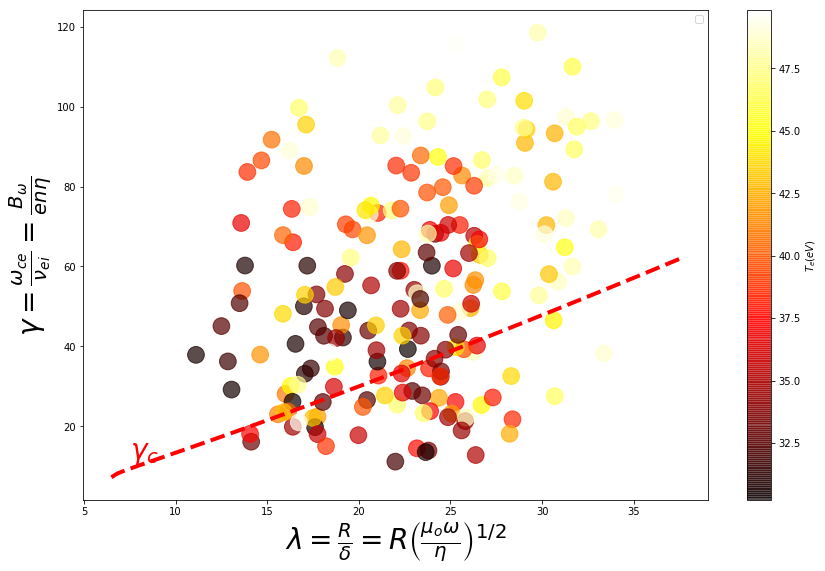

In [2]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

def plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,scaler,title):
    
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:,1].reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    levels = np.linspace(0.,1.,21)
    sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
    plt.colorbar(sc, label='Probability of Reversal')
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    ln = ['no_train','yes_train']
    
    X_set = scaler.inverse_transform(X_train)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
        
    lt = ['no_test','yes_test']
    X_tt = scaler.inverse_transform(X_test)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_tt[y_test==j, 0], X_tt[y_test==j,1],
                    c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
    
    #xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    xx = np.linspace(6.5,40.,1000)
    plt.plot(xx,gammaCritical(xx),'k--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    #plt.legend()

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')
plt.savefig("figure1.png",dpi=300)

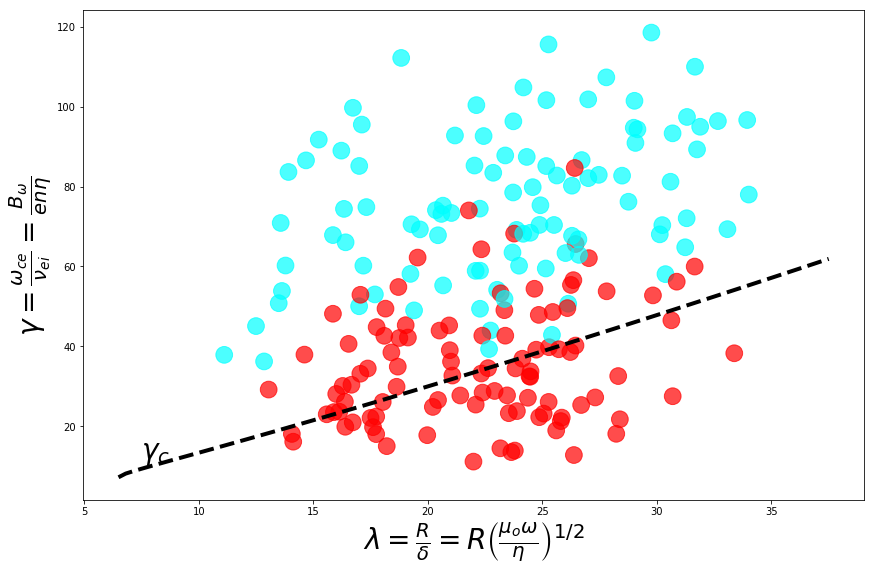

In [3]:
## Get the data
thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
frc = np.genfromtxt('frc_post_data.txt')

plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap=ListedColormap(('red', 'cyan')), alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'k--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='black')
plt.savefig("figure2.png",dpi=300)

In [4]:
# lets separate the features and the targets
X = frc[:,3:5]
y = frc[:,11]

# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

# Scale the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [5]:
help(LogisticRegression)
# Create the hyperparameter grid
c_space = np.linspace(3, 4, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
 |  both dense and sparse input. Use C-ordered arrays or CSR matrices
 |  containing 64-bit floats for optimal performance; any other input format
 |  will be converted (and copied).
 |  
 |  The 'newton-cg', 'sag', and 'lbfgs' solve

In [6]:
# fitting logistic Regression to the training set
log_reg = LogisticRegression(random_state=0)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 3.4210526315789473, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.8866666666666667


In [7]:
log_reg = LogisticRegression(random_state=0, penalty='l2', C=3.4210526315789473)
log_reg.fit(X_train, y_train)

LogisticRegression(C=3.4210526315789473, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [8]:
# predict the test set results
y_pred = log_reg.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[22  1]
 [ 4 23]]


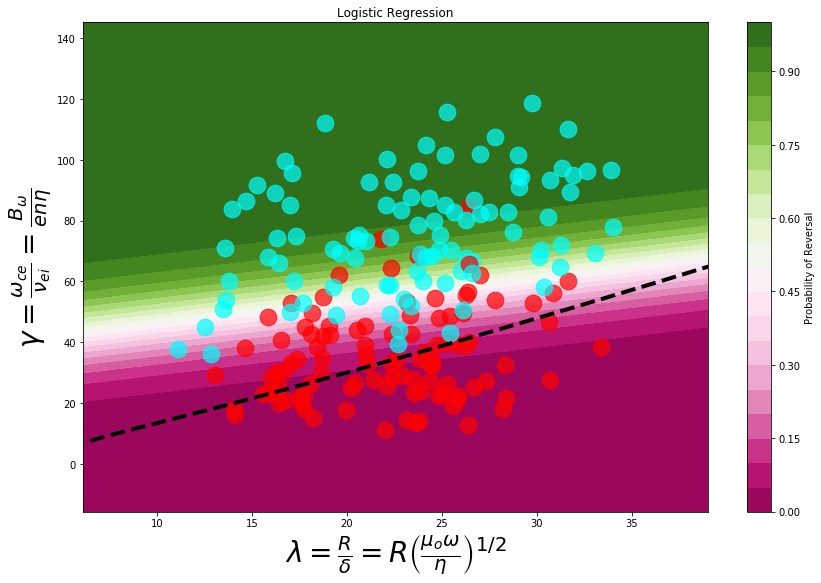

In [9]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,log_reg,sc_X,'Logistic Regression')
plt.savefig("figure3.png",dpi=300)

In [10]:
# Analysis
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob)

In [11]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors.classification:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [ca

In [12]:
param_grid = {'n_neighbors': np.arange(1, 50),
              'p': np.arange(1,5)} # grid dictionary
knn_class = KNeighborsClassifier(metric='minkowski')
knn_cv = GridSearchCV(knn_class, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned K-Nearest Neighbors Parameter: {}".format(knn_cv.best_params_))
print("Tuned K-Nearest Neighbors Accuracy: {}".format(knn_cv.best_score_))

Tuned K-Nearest Neighbors Parameter: {'n_neighbors': 5, 'p': 1}
Tuned K-Nearest Neighbors Accuracy: 0.8933333333333333


[[20  3]
 [ 5 22]]


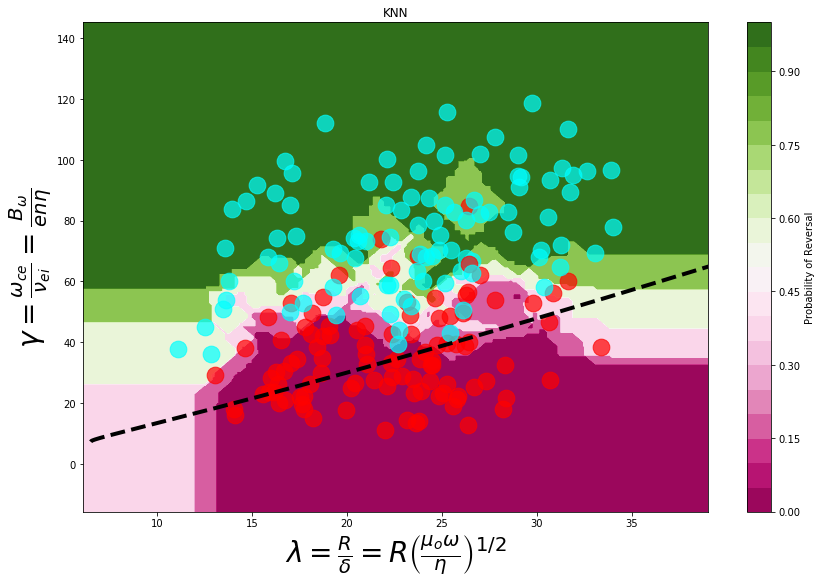

In [13]:
## K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1) # euclidian distances
knn.fit(X_train,y_train)
# predict the test set results
y_pred = knn.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,knn,sc_X,'KNN')
plt.savefig("figure4.png",dpi=300)

In [14]:
# Analysis
y_pred_prob = knn.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob)

In [15]:
help(SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  kernel : string, optional (default='rbf')
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly

In [16]:
param_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'degree': np.arange(1,5),
              'gamma': np.logspace(-5,-3,10)}
scv_class = SVC(random_state=0, probability=True)
cv = GridSearchCV(scv_class, param_grid, cv=5)
cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

Tuned SVM Parameter: {'degree': 1, 'gamma': 1e-05, 'kernel': 'linear'}
Tuned SVM Accuracy: 0.8733333333333333


[[22  1]
 [ 5 22]]


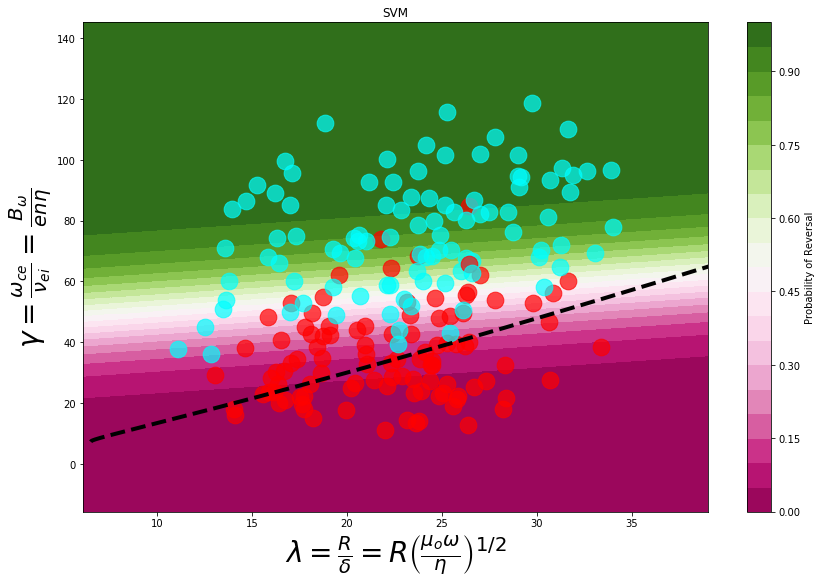

In [17]:
# fit SVM to the data
svc_class = SVC(kernel='linear', random_state=0, probability=True, gamma=0.0001) ## kernels: 'linear, 'rbf'
svc_class.fit(X_train,y_train)

# predict the test set results
y_pred = svc_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,svc_class,sc_X,'SVM')
plt.savefig("figure5.png",dpi=300)

In [18]:
# Analysis
y_pred_prob = svc_class.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prob)

In [19]:
help(GaussianNB)

Help on class GaussianNB in module sklearn.naive_bayes:

class GaussianNB(BaseNB)
 |  Gaussian Naive Bayes (GaussianNB)
 |  
 |  Can perform online updates to model parameters via `partial_fit` method.
 |  For details on algorithm used to update feature means and variance online,
 |  see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
 |  
 |      http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
 |  
 |  Read more in the :ref:`User Guide <gaussian_naive_bayes>`.
 |  
 |  Parameters
 |  ----------
 |  priors : array-like, shape (n_classes,)
 |      Prior probabilities of the classes. If specified the priors are not
 |      adjusted according to the data.
 |  
 |  Attributes
 |  ----------
 |  class_prior_ : array, shape (n_classes,)
 |      probability of each class.
 |  
 |  class_count_ : array, shape (n_classes,)
 |      number of training samples observed in each class.
 |  
 |  theta_ : array, shape (n_classes, n_features)
 |      mean of eac

[[20  3]
 [ 6 21]]
SVM Accuracy: 0.82


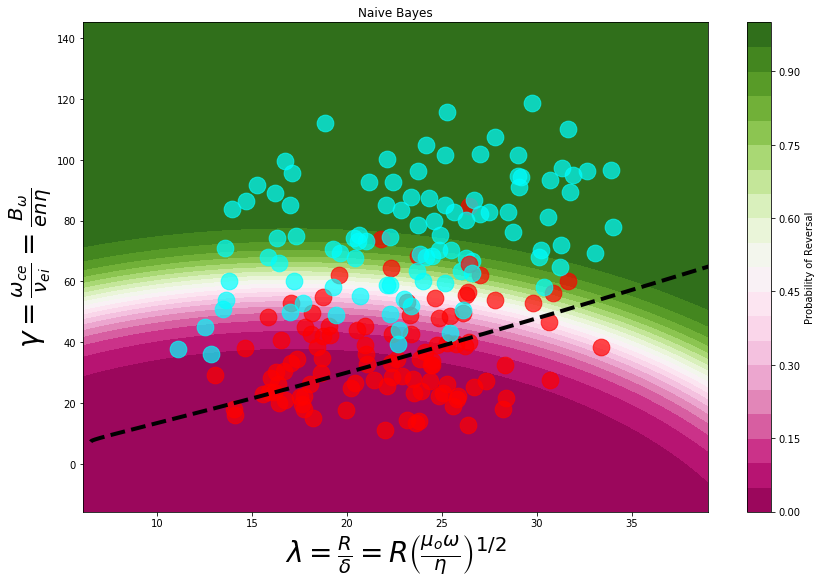

In [20]:
# Fit Naive Bayes to the data
naive_B = GaussianNB()
naive_B.fit(X_train,y_train)

# predict the test set results
y_pred = naive_B.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,naive_B,sc_X,'Naive Bayes')
plt.savefig("figure6.png",dpi=300)
print("SVM Accuracy: {}".format(accuracy_score(y_test, y_pred, normalize=True)))

In [21]:
# SVM Analysis
y_pred_prob = naive_B.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prob)

In [22]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl

In [23]:
param_grid = {"max_depth": [3, 4, 5, None],
              "n_estimators": np.arange(10,110,10),
              "criterion": ["gini", "entropy"]}
ran_forrest = RandomForestClassifier(random_state=0)
cv = GridSearchCV(ran_forrest, param_grid, cv=5)

cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

Tuned SVM Parameter: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 60}
Tuned SVM Accuracy: 0.8933333333333333


[[21  2]
 [ 4 23]]


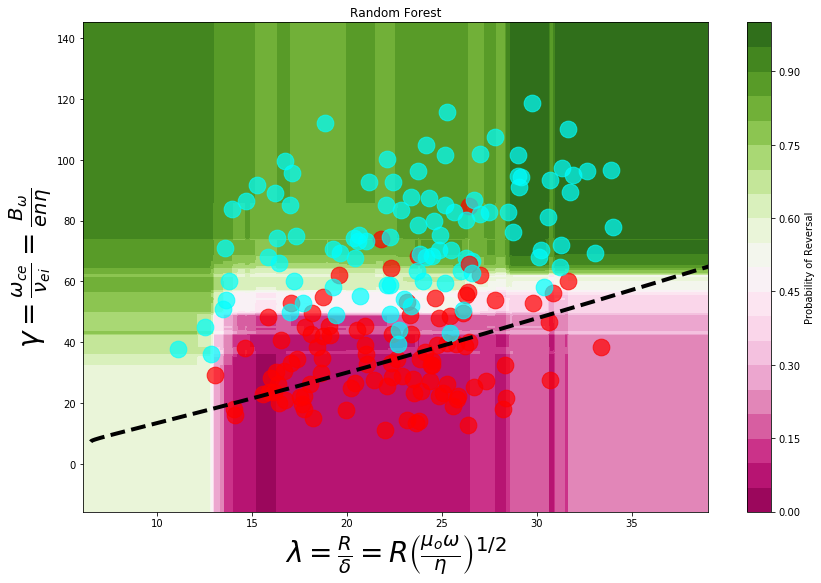

In [24]:
# Fit Random Forest to the training data
ran_forrest = RandomForestClassifier(n_estimators=60, criterion='gini', max_depth=3, random_state=0)
ran_forrest.fit(X_train,y_train)

# predict the test set results
y_pred = ran_forrest.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,ran_forrest,sc_X,'Random Forest')
plt.savefig("figure7.png",dpi=300)

In [27]:
# Analysis
y_pred_prob = ran_forrest.predict_proba(X_test)[:,1]
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_prob)

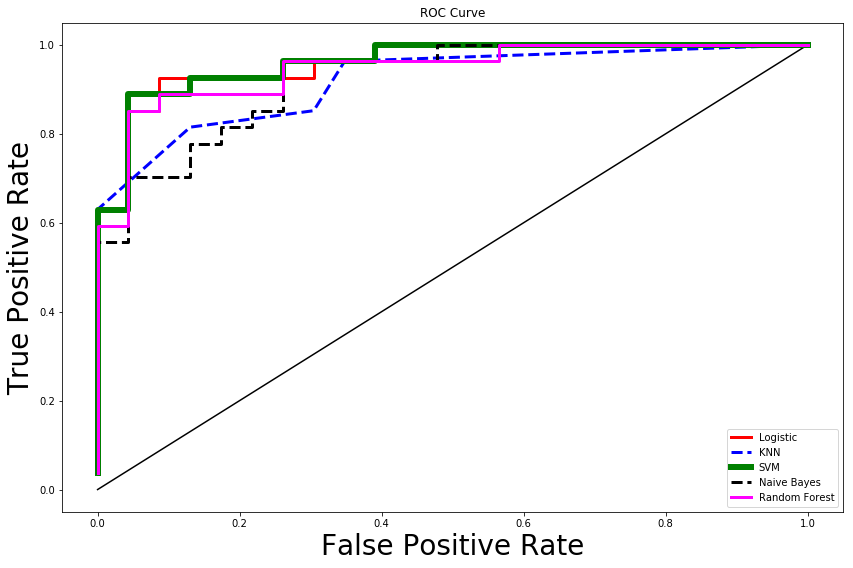

In [28]:
plt.figure(figsize=(14,9))
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr1, tpr1, 'r',  label='Logistic',lw=3)
plt.plot(fpr2, tpr2, 'b--',label='KNN',lw=3)
plt.plot(fpr3, tpr3, 'g',label='SVM',lw=6)
plt.plot(fpr4, tpr4, 'k--',label='Naive Bayes',lw=3)
plt.plot(fpr5, tpr5, color='magenta',label='Random Forest',lw=3)
plt.xlabel('False Positive Rate',fontsize=28)
plt.ylabel('True Positive Rate',fontsize=28)
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("figure8.png",dpi=300)

It looks like the best performing classifiears are Logistic, SVM, and Random Forest. What we will do next is create a voting classifier.

/home/sousae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[22  1]
 [ 4 23]]


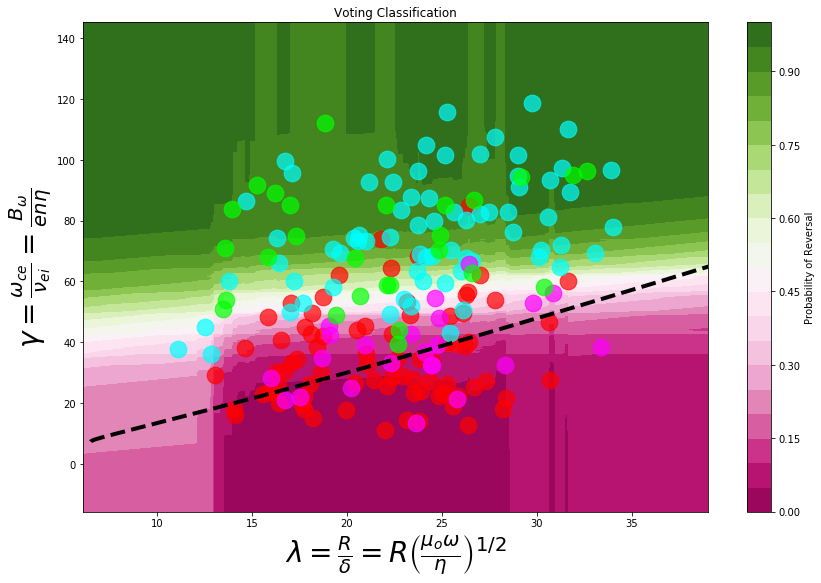

In [29]:
voting_class = VotingClassifier(estimators=[('lr',log_reg), ('rf', ran_forrest), ('svc', svc_class)], voting='soft')
voting_class.fit(X_train,y_train)

# predict the test set results
y_pred = voting_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,voting_class,sc_X,'Voting Classification')
plt.savefig("figure9.png",dpi=300)

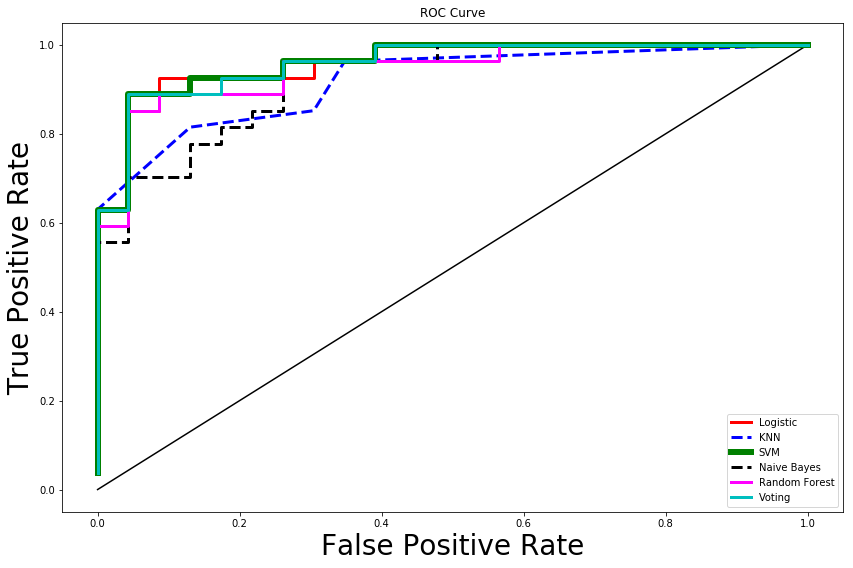

In [30]:
# Analysis
y_pred_prob = voting_class.predict_proba(X_test)[:,1]
fpr6, tpr6, thresholds6 = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(14,9))
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr1, tpr1, 'r',  label='Logistic',lw=3)
plt.plot(fpr2, tpr2, 'b--',label='KNN',lw=3)
plt.plot(fpr3, tpr3, 'g',label='SVM',lw=6)
plt.plot(fpr4, tpr4, 'k--',label='Naive Bayes',lw=3)
plt.plot(fpr5, tpr5, color='magenta',label='Random Forest',lw=3)
plt.plot(fpr6, tpr6, 'c',  label='Voting',lw=3)
plt.xlabel('False Positive Rate',fontsize=28)
plt.ylabel('True Positive Rate',fontsize=28)
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("figure10.png",dpi=300)

## Trying some boosting techniques.

In [31]:
help(AdaBoostClassifier)

Help on class AdaBoostClassifier in module sklearn.ensemble.weight_boosting:

class AdaBoostClassifier(BaseWeightBoosting, sklearn.base.ClassifierMixin)
 |  An AdaBoost classifier.
 |  
 |  An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
 |  classifier on the original dataset and then fits additional copies of the
 |  classifier on the same dataset but where the weights of incorrectly
 |  classified instances are adjusted such that subsequent classifiers focus
 |  more on difficult cases.
 |  
 |  This class implements the algorithm known as AdaBoost-SAMME [2].
 |  
 |  Read more in the :ref:`User Guide <adaboost>`.
 |  
 |  Parameters
 |  ----------
 |  base_estimator : object, optional (default=DecisionTreeClassifier)
 |      The base estimator from which the boosted ensemble is built.
 |      Support for sample weighting is required, as well as proper `classes_`
 |      and `n_classes_` attributes.
 |  
 |  n_estimators : integer, optional (default=50)
 |    

In [32]:
ada_class = AdaBoostClassifier(SVC(kernel='linear', random_state=0, probability=True, gamma=0.0001), 
                               n_estimators=200,algorithm='SAMME.R', learning_rate=0.5)

ada_class.fit(X_train,y_train)

# predict the test set results
y_pred = voting_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[22  1]
 [ 4 23]]


/home/sousae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


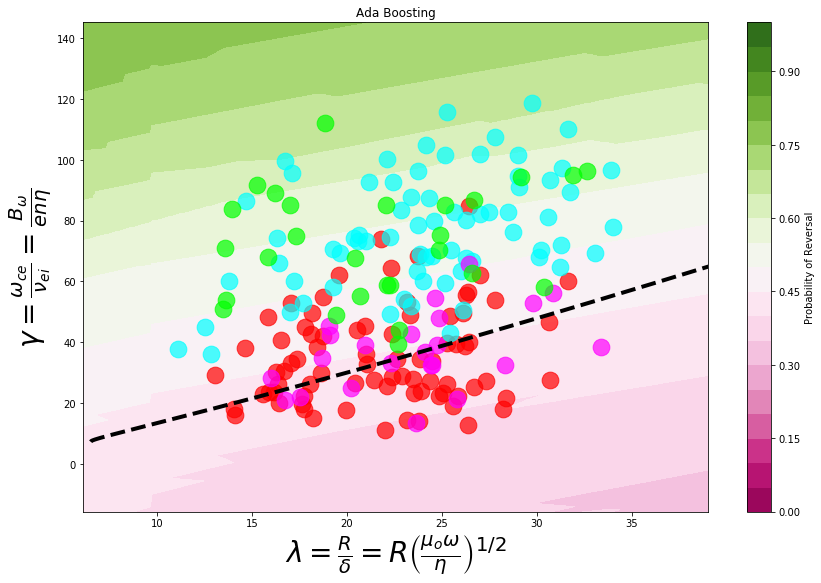

In [33]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,ada_class,sc_X,'Ada Boosting')
plt.savefig("figure11.png",dpi=300)

In [34]:
help(GradientBoostingClassifier)

Help on class GradientBoostingClassifier in module sklearn.ensemble.gradient_boosting:

class GradientBoostingClassifier(BaseGradientBoosting, sklearn.base.ClassifierMixin)
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special case where only a single regression tree is induced.
 |  
 |  Read more in the :ref:`User Guide <gradient_boosting>`.
 |  
 |  Parameters
 |  ----------
 |  loss : {'deviance', 'exponential'}, optional (default='deviance')
 |      loss function to be optimized. 'deviance' refers to
 |      deviance (= logistic regression) for classification
 |      with probabilistic outputs. For loss 'exponential' gradient
 |      boosting recovers the AdaBoost a

In [35]:
param_grid = {"max_depth": [2, 3, 4, 5, None],
              "n_estimators": np.arange(10,110,10),
              "learning_rate": np.arange(0.1,1.,0.1),
              "criterion": ["friedman_mse", "mse", "mae"]}
grad_boost = GradientBoostingClassifier(random_state=0)
cv = GridSearchCV(grad_boost, param_grid, cv=5)

cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

Tuned SVM Parameter: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 40}
Tuned SVM Accuracy: 0.8933333333333333


In [36]:
grad_boost = GradientBoostingClassifier(max_depth=2, n_estimators=40, learning_rate=0.1)
grad_boost.fit(X_train,y_train)

# predict the test set results
y_pred = grad_boost.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[22  1]
 [ 5 22]]


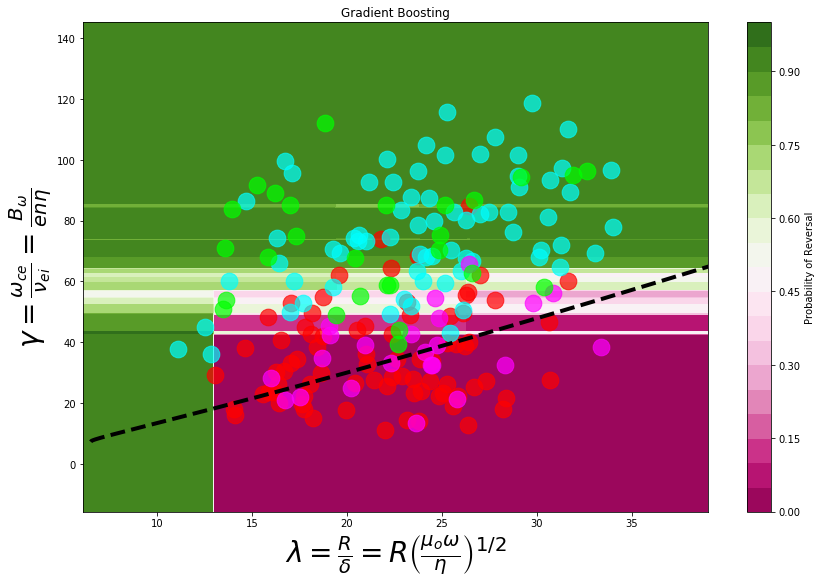

In [37]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,grad_boost,sc_X,'Gradient Boosting')
plt.savefig("figure12.png",dpi=300)